In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
from utils import calculate_feature_importance
import seaborn as sns
import matplotlib.pyplot as plt

from modify_df import ic50_binary, split_df_by_cell_line, split_df_by_drugname

from create_model import defineSplits, create_all_models, make_logres_model, make_svc_model, make_gb_model
from create_model import define_splits_for_regression


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
drugname = '5-Fluorouracil'

In [4]:
train =  pd.read_csv("./data/Training_data.csv")
train.rename(columns={"DRUG_NAME":"Drug Name", 'CELL_LINE_NAME': 'Cell Line Name'}, inplace = True)



In [ ]:


train = train[train['Drug Name'] == drugname]

In [ ]:
train_x = train.drop(['LN_IC50','Cell Line Name', 'Drug Name'],axis =1)
train_y = train['LN_IC50']

threshold = 0.9
splits = define_splits_for_regression(train_x,train_y)

In [ ]:
create_all_models(X=train_x,
                   y=train_y, 
                   y_featname='LN_IC50',
                   cor_threshold=threshold, 
                   cv= splits,
                   test = False,
                   model_iter = 100,
                   search_iter = 10,
                   unique_name_of_dir = "GeneticPathway",
                   make_linres = True,
                   make_svc = False,
                   make_gb = True)

In [5]:
test = pd.read_csv("./data/Test_data.csv")
test.columns = train.columns

In [6]:
test = test[test['Drug Name'] == drugname]

In [7]:
test_x = test.drop(['LN_IC50','Cell Line Name', 'Drug Name'],axis =1)
test_y = test['LN_IC50']

In [8]:
model_dir = './models_made/GeneticPathway_2023_9_26_17_35_27_randvar_123_cor_0.9_yvar_LN_IC50'

## Feature Importance

In [9]:
linres_score = calculate_feature_importance(test_x,test_y, model_dir+'/linres')
gb_score = calculate_feature_importance(test_x,test_y, model_dir+'/gb')
#svc_score = calculate_feature_importance(test_x,test_y, model_dir+'/svc')

In [10]:
linres_score.rename(columns={'z-score': 'Linear Regression'}, inplace=True)
gb_score.rename(columns={'z-score': 'Gradient Boosting'}, inplace=True)
#svc_score.rename(columns={'z-score': 'Support Vector Machine'}, inplace=True)

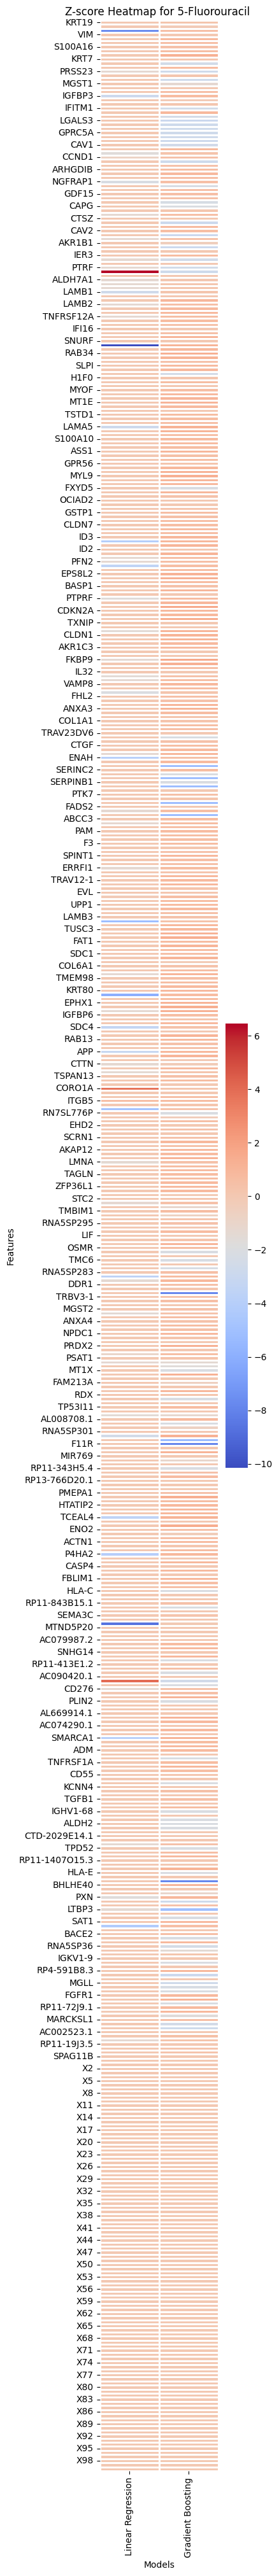

In [19]:
#all_score = pd.concat([logres_score,gb_score,svc_score], axis=1)
all_score = pd.concat([linres_score,gb_score], axis=1)
fig, ax = plt.subplots(figsize=(3, 50))

coloring = "coolwarm" #coolwarm, autumn, RdGy,  cividis, inferno, viridis, cool

sns.heatmap(all_score, cmap=coloring, annot=False, fmt=".3f", ax=ax,linewidths=1)


ax.set_xlabel("Models")
ax.set_ylabel("Features")
ax.set_title(f"Z-score Heatmap for {drugname} ")

plt.show()

os.makedirs('./graphs/zscore',exist_ok=True)


## ML model prediction and outcomes df